In [11]:
# Import libraries
import gensim.downloader as api
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Conv1D, Dense, Embedding, LSTM, GlobalMaxPooling1D, MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
# Import preprocessing method
from preprocessing import preprocess

In [3]:
# Define constants
BATCH_SIZE = 128
ENCODED_VECTOR_SIZE = 300
LSTM_SIZE = 100
MAX_WORDS = 10000
NUM_CLASSES = 20
NUM_EPOCHS = 10
OUTPUT_SIZE = 100
TEST_SIZE = 0.2
VALIDATION_SPLIT = 0.1

In [4]:
# Load datasets
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers'))
texts = newsgroups.data
labels = newsgroups.target

In [5]:
# Preprocess texts
preprocessed_texts = [preprocess(text) for text in texts]

# Instantiate tokenizer
# tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer = Tokenizer()

# Tokenize words from samples
tokenizer.fit_on_texts(preprocessed_texts)
num_words = len(tokenizer.word_index) + 1

# Convert to vetorized sequences 
sequences = tokenizer.texts_to_sequences(preprocessed_texts)

# Pad sequences to all be same size
# padded_sequences = pad_sequences(sequences)
padded_sequences = pad_sequences(sequences, maxlen=ENCODED_VECTOR_SIZE)

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=TEST_SIZE, shuffle=True)

In [6]:
# Load in embeddings
embeddings = api.load("word2vec-google-news-300")

# Create embedding matrix
embedding_matrix = np.zeros((num_words, ENCODED_VECTOR_SIZE))
for word, index in tokenizer.word_index.items():
    if word in embeddings:
        embedding_matrix[index] = embeddings[word]

In [7]:
# Define CNN model
model = Sequential([
    Embedding(input_dim=num_words, output_dim=ENCODED_VECTOR_SIZE, weights=[embedding_matrix], input_length=ENCODED_VECTOR_SIZE, trainable=False),
    Conv1D(BATCH_SIZE, 5, activation="relu"),
    MaxPooling1D(3),
    Conv1D(BATCH_SIZE, 5, activation="relu"),
    LSTM(LSTM_SIZE),
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          44484000  
                                                                 
 conv1d (Conv1D)             (None, 296, 128)          192128    
                                                                 
 max_pooling1d (MaxPooling1  (None, 98, 128)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 94, 128)           82048     
                                                                 
 lstm (LSTM)                 (None, 100)               91600     
                                                                 
 dense (Dense)               (None, 20)                2020      
                                                        

In [8]:
# Train the model
model_history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_split=VALIDATION_SPLIT)

Epoch 1/10
106/106 [==============================] - 37s 344ms/step - loss: 2.1501 - accuracy: 0.2773 - val_loss: 1.5972 - val_accuracy: 0.4602
Epoch 2/10
106/106 [==============================] - 35s 330ms/step - loss: 1.4435 - accuracy: 0.4974 - val_loss: 1.3941 - val_accuracy: 0.5219
Epoch 3/10
106/106 [==============================] - 37s 345ms/step - loss: 1.1733 - accuracy: 0.6002 - val_loss: 1.1488 - val_accuracy: 0.6214
Epoch 4/10
106/106 [==============================] - 41s 384ms/step - loss: 0.9932 - accuracy: 0.6625 - val_loss: 1.0674 - val_accuracy: 0.6532
Epoch 5/10
106/106 [==============================] - 38s 357ms/step - loss: 0.8891 - accuracy: 0.7044 - val_loss: 1.0112 - val_accuracy: 0.6870
Epoch 6/10
106/106 [==============================] - 43s 409ms/step - loss: 0.7542 - accuracy: 0.7513 - val_loss: 0.9560 - val_accuracy: 0.6983
Epoch 7/10
106/106 [==============================] - 38s 355ms/step - loss: 0.6802 - accuracy: 0.7752 - val_loss: 0.9400 - val_ac

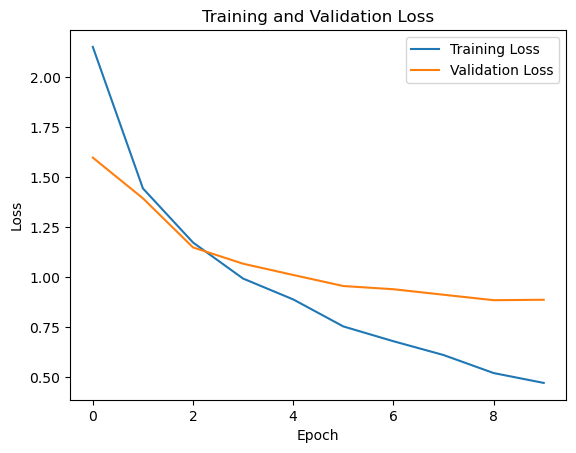

In [12]:
# Plot loss curves
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
# Get predictions and calculate accuracy
predictions = np.argmax(model.predict(x_test), axis=1)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

118/118 [==============================] - 11s 87ms/step
Accuracy: 0.7180371352785145
